In [1]:
import sys
import cuentitas
from auxiliares import generadorHH, generadorFran  #generador, generador1E, generadorEmisividad, 

from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd
import glob
import theano.tensor as TT
import random

import time

import pymc3 as pm

sns.set() #seaborn como default

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def toFitHH(ep1,ep2,d,s1,l1,s2,l2,anguloR,landa): #Me devuelve un tensor de nn+mm, con nn valores de angulos s0 y mm emis
    if (ep1 != ep2):
        s0s = generadorHH(ep1,ep2,d,s1,l1,s2,l2,incAng,landa)
    
        pp = len(s0s[1])
    
        a = TT.zeros(pp)
#     print(s0s[1][0])
        for i in range(pp):
            a = TT.set_subtensor(a[i], s0s[1][i])
    
    
    return a

In [3]:
# angWR es el angulo sin ruido para simulaciones con emisividad, es indistinto el valor 
# que tome si uso la f() sin emisividad
def modelo(sector, angWR, landa, samples, sigmas): 
    
    phi = np.pi
    
    print(sector[1])
    print(sector[1].shape)

    
    ranges = {}
    ranges['ep1'] = 1.40001, 8 #corro ligeramente el punto inicial ep1 para que no diverja con ep2 en canal HH
    ranges['ep2'] = 1.4, 8
    ranges['d'] = 0.001, 0.5
    ranges['s1'] = 0.0004, 0.004
    ranges['s2'] = 0.0004, 0.004

    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
        ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
        d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
        s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])
        s2 = pm.Uniform('s2', ranges['s2'][0], ranges['s2'][1])

    def f(ep1 = ep1,
          ep2 = ep2,
          d = d,
          s1 = s1,
          s2 = s2):

        return toFitHH(ep1,ep2,d,s1,0.015,s2,0.01,sector[0],landa)
    
    with model:
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=sector[1])
        trace = pm.sample_smc(samples, cores=4, parallel=True)  
    
    return trace

In [4]:
# incAng = [15,20,25,35,40]
# landa = [0.025]

# incAng = [15,20,25]
# landa = [0.025]

# incAng = [20]
# landa = [0.025]


# incAng = [20]
# landa = [0.025,0.05]

incAng = [20,60]
landa = [0.025]


# incAng = [15,20,25]
# landa = [0.025,0.05]

# incAng = [20]
# surfaceModelParam = [1.93,5,0.05,0.0017,0.015,0.003,0.01]
# surfaceModelParam = [1.93,
#                      5.0,
#                      0.3,
#                      0.001,
#                      0.01,
#                      0.002,
#                      0.01] #set1
# surfaceModelParam = [1.93,5,0.05,0.0017,0.015,0.003,0.01] #set2

# set1
generadorHH(1.93,5.0,0.3,0.001,0.015,0.002,0.01,incAng,landa)
# generadorVV(1.93,5.0,0.3,0.001,0.015,0.002,0.01,incAng,landa)

# set3
# generadorHH(1.93,
#                   5.0,
#                      0.3,
#                      0.001,
#                      0.01,
#                      0.001,
#                      0.01,
#               incAng,
#              landa)
# generadorFranSoloS0(incAng, surfaceModelParam)

array([array([20, 60]), array([ -4.99560838, -31.00460095,   0.95506814])],
      dtype=object)

In [5]:
qw = toFitHH(1.93,
            5.0,
            0.3,
            0.001,
            0.015,
            0.002,
            0.01,
            incAng,
            landa)

In [6]:
qw.eval()

array([ -4.99560838, -31.00460095,   0.95506814])

In [19]:
# m = 51
# X,Y,Wt = ig(m-1)

t0 = time.time()


muestras = 20000
Nombre = 'Delta'

#------------ error para generador1E() ------------#
#sig = np.asarray(len(angR)*[noiseSTD**2] + [0.05])

# sig = np.asarray(len(angR)*[0.1] + [0.01]) #original Javi

# sig = np.asarray(len(incAng)*[0.1] + [0.01])  #pruebas error

sig = np.asarray(len(incAng)*len(landa)*[0.1] + len(landa)*[0.01])

# sig = np.asarray(len(incAng)*[0.1])  #pruebas error

#set3
traza = modelo(generadorHH(1.93,
                              5.0,
                              0.3,
                              0.001,
                              0.015,
                              0.002,
                              0.01,
                              incAng,
                              landa),
                              np.asarray([10]),
                              landa,
                              muestras,
                              sig)
 
#------------ error para generadorEmisividad()) ------------#
# sig = np.asarray(len(angR)*[noiseSTD**2] + len(ang)*[0.001])
# traza = modelo([angR,seR],ang,muestras,sig)

[ -4.99560838 -31.00460095   0.95506814]
(3,)


Initializing SMC sampler...
Sampling 4 chains in 4 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. 

In [20]:
plotear = np.stack((traza['ep1'],traza['ep2'],traza['d'], traza['s1'], traza['s2'])).T
dfplotear = pd.DataFrame(plotear, columns = ['ep1','ep2','d','s1','s2'])

In [21]:
# modelIn = [1.93,5,0.05,0.0017,0.015,0.003,0.01]
# modelInReduced = [surfaceModelParam[0], 
#                   surfaceModelParam[1],
#                   surfaceModelParam[2],
#                   surfaceModelParam[3],
#                   surfaceModelParam[5]]

modelInReduced = [1.93,
                  5.0,
                  0.3,
                  0.001,
                  0.002]

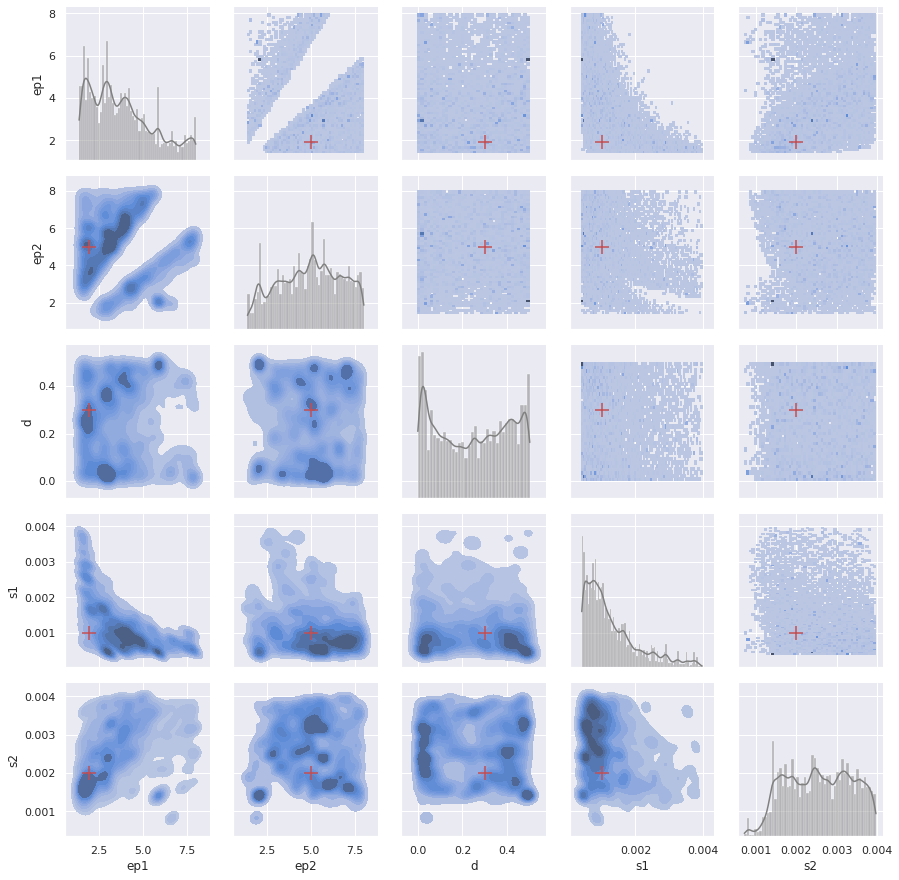

In [22]:
f = sns.PairGrid(dfplotear)
# f.fig.suptitle(Nombre, y=1.01, fontsize = 'large')
f.map_upper(sns.histplot)

f.map_lower(sns.kdeplot, fill=True)
f.map_diag(sns.histplot, kde=True, color='.5')

for i in range(5):
    for j in range(5):
        if i == j:
            #ploteo el valor verdadero en las marginales
#             f.axes[j,i].axvline(modelInReduced[i], color='r', linestyle='dashed', linewidth=1)
            pass
        else:
            f.axes[j,i].scatter(modelInReduced[i], modelInReduced[j], marker="+", c='r', s=200) #color='k', linestyle='dashed', linewidth=1)
            
            
#         f.axes[j,i].xaxis.set_label_text(xlabels[i])
#         f.axes[j,i].yaxis.set_label_text(ylabels[j])
#         f.axes[j,i].xaxis.set_label_text(xlabels[i])
#         f.axes[j,i].scatter(1,1)



In [23]:
t1 = time.time()
print("Tiempo de ejecución:", t1-t0, 'seg','(', (t1-t0)/3600,  'hs )')

nombre = "set1-2Capas-noNoise-2s0+1emi-20000-1lambda-6020-3"
f.savefig('Resultados_HH/'+nombre+'.png', dpi=300)

Tiempo de ejecución: 3419.3249094486237 seg ( 0.94981247484684 hs )


In [24]:
e1 = traza['ep1']
e2 = traza['ep2']
d = traza['d']
s1 = traza['s1']
s2 = traza['s2']

guardar = [e1,e2,d,s1,s2]

f_ = np.savetxt('Resultados_HH/'+nombre+'Trazas.txt', guardar, delimiter=';')
f2_ = np.savetxt('Resultados_HH/'+nombre+'Trazas-input.txt', np.asarray([np.asarray(incAng),np.asarray(modelInReduced)],dtype=object), fmt='%s', delimiter=';')